In [1]:
import pandas
import time
from scipy.stats import lognorm
from sklearn.preprocessing import StandardScaler
import numpy as np
seed = 71
np.random.seed = seed

import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

from qiskit import Aer, QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal, UniformDistribution, NormalDistribution

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import NumPyDiscriminator, QGAN

from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation
from qiskit.finance.applications import EuropeanCallExpectedValue

algorithm_globals.random_seed = seed

D:\Anaconda\lib\site-packages\qiskit\aqua\__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
D:\Anaconda\lib\site-packages\qiskit\finance\__init__.py:50: DeprecationWarning: The package qiskit.finance is deprecated. It was moved/refactored to qiskit_finance (pip install qiskit-finance). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('finance', 'qiskit_finance', 'qiskit-finance')


In [2]:
ep_list_1 = []
ep_train_list_1 =[]
estimate_list_1 = []
times_list_1 = []
in_ci_1 = 0
run_time_1 = 0

N = 1000
qubits_num = 3
num_epochs = 5
batch_size = int(N/num_epochs)    
    
data = []
data = pandas.read_csv("ttt.csv", names=["price"])
scaler = StandardScaler()
data_list = scaler.fit_transform(data)
data_arr = np.array(data_list)
actual_data = data_arr.astype(float)
    
sigma,loc,scale = stats.lognorm.fit(actual_data)
estimated_mu = np.log(scale)
estimated_sigma = sigma

load_num_qubits = [qubits_num]
k = len(load_num_qubits)
load_bounds = np.array([0, (2 ** load_num_qubits[0]) -1])
init_dist = UniformDistribution(sum(load_num_qubits))
ansatz = TwoLocal(int(np.sum(load_num_qubits)), 'ry', 'cz', 'linear', reps=1, insert_barriers=True)
first_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi

for times in range(1, 101):
    
    start = time.process_time()
    
    real_data = np.random.lognormal(mean=estimated_mu, sigma=estimated_sigma, size=N)
    Dmin = real_data.min()
    Dmax = real_data.max()
    '''
    N = 1000
    qubits_num = 5
    num_epochs = 5
    
    data = []
    data = pandas.read_csv("ttt.csv", names=["price"])
    scaler = StandardScaler()
    data_list = scaler.fit_transform(data)
    data_arr = np.array(data_list)
    actual_data = data_arr.astype(float)
    
    sigma,loc,scale = stats.lognorm.fit(actual_data)
    estimated_mu = np.log(scale)
    estimated_sigma = sigma
    

    
    
    load_num_qubits = [qubits_num]
    k = len(load_num_qubits)
    load_bounds = np.array([0, (2 ** load_num_qubits[0]) -1])

    batch_size = int(N/num_epochs)
    '''
    qgan = QGAN(real_data, load_bounds, load_num_qubits, batch_size, num_epochs, snapshot_dir=None)
    qgan.seed = 11
    quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'),
                                   seed_transpiler=seed, seed_simulator=seed)
    '''

    init_dist = UniformDistribution(sum(load_num_qubits))
    ansatz = TwoLocal(int(np.sum(load_num_qubits)), 'ry', 'cz', 'linear', reps=1, insert_barriers=True)
    '''
    init_params = first_params
    load_g_circuit = ansatz.compose(init_dist, front=True)

    qgan.set_generator(generator_circuit=load_g_circuit, generator_init_params=init_params)
    qgan._generator._free_parameters = sorted(load_g_circuit.parameters, key=lambda p: p.name)
    discriminator = NumPyDiscriminator(len(load_num_qubits))
    qgan.set_discriminator(discriminator)

    result = qgan.run(quantum_instance)
    
    op_bounds = np.array([0 , (2 ** load_num_qubits[0]) -1])
    op_num_qubits = load_num_qubits[0]
    g_params = result['params_g']
    init_dist = NormalDistribution(op_num_qubits, mu=estimated_mu, sigma=estimated_sigma, bounds=op_bounds)
    var_form = TwoLocal(op_num_qubits, 'ry', 'cz', entanglement='circular', reps=1)
    theta = var_form.ordered_parameters
    op_g_circuit = init_dist.compose(var_form)

    strike_price = 2
    c_approx = 0.25
    european_call_objective = EuropeanCallExpectedValue(
        op_num_qubits,
        strike_price=strike_price,
        rescaling_factor=c_approx,
        bounds=op_bounds
    )
    
    values = [op_bounds[0] + (op_bounds[1] - op_bounds[0]) * x / (2 ** op_num_qubits - 1) for x in range(2**op_num_qubits)]
    uncertainty_model = op_g_circuit.assign_parameters(dict(zip(theta, g_params)))
    amplitudes = Statevector.from_instruction(uncertainty_model).data

    x = np.array(values)
    y = np.abs(amplitudes) ** 2

    N = 1000
    log_normal = np.random.lognormal(mean=estimated_mu, sigma=estimated_sigma, size=N)
    log_normal = np.round(log_normal)
    log_normal = log_normal[log_normal <= (2 ** op_num_qubits) -1]
    log_normal_samples = []
    for i in range(2 ** op_num_qubits):
        log_normal_samples += [np.sum(log_normal==i)]
    log_normal_samples = np.array(log_normal_samples / sum(log_normal_samples))

    payoff = []
    for i in range(2 ** op_num_qubits):
        if i <= strike_price:
            payoff.append(0)
        else:
            payoff.append(i - strike_price)
    payoff = np.array(payoff)

    ep = np.dot(log_normal_samples, payoff)
    ep_trained = np.dot(y, payoff)
    european_call = european_call_objective.compose(uncertainty_model, front=True)
    epsilon = 0.01
    alpha = 0.05

    ae = IterativeAmplitudeEstimation(epsilon=epsilon, alpha=alpha,
                                      state_preparation=european_call,
                                      objective_qubits=[op_num_qubits],
                                      post_processing=european_call_objective.post_processing)
    END_result = ae.run(quantum_instance = Aer.get_backend('qasm_simulator'), shots = 10000)
    
    conf_int = np.array(END_result['confidence_interval'])
    print('Target value:       \t%.4f' % ep)
    print('Exact value:        \t%.4f' % ep_trained)
    print('Estimated value:    \t%.4f' % (END_result['estimation']))
    print('Confidence interval:\t[%.4f, %.4f]' % tuple(conf_int))
    print(times)
    print(num_epochs)
    end = time.process_time()
    print("執行時間：%f 秒" % (end - start))

    if conf_int[0] <= ep <= conf_int[1]:
        in_ci_1 += 1
        
    run_time_1 += (end - start)
    ep_list_1.append(ep)
    ep_train_list_1.append(ep_trained)
    estimate_list_1.append((END_result['estimation']))
    times_list_1.append(times)

D:\Anaconda\lib\site-packages\qiskit\aqua\quantum_instance.py:135: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_class('aqua.QuantumInstance',
D:\Anaconda\lib\site-packages\qiskit\aqua\algorithms\amplitude_estimators\ae_algorithm.py:91: DeprecationWarning: The package qiskit.aqua.algorithms.amplitude_estimators is deprecated. It was moved/refactored to qiskit.algorithms.amplitude_estimators (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.amplitude_estimators',
D:\Anaconda\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release

Target value:       	1.5743
Exact value:        	1.9254
Estimated value:    	1.9433
Confidence interval:	[1.9395, 1.9472]
1
5
執行時間：40.671875 秒
Target value:       	1.6273
Exact value:        	1.9263
Estimated value:    	1.9413
Confidence interval:	[1.9366, 1.9459]
2
5
執行時間：36.140625 秒
Target value:       	1.6058
Exact value:        	1.9263
Estimated value:    	1.9450
Confidence interval:	[1.9408, 1.9492]
3
5
執行時間：38.609375 秒
Target value:       	1.5668
Exact value:        	1.9262
Estimated value:    	1.9401
Confidence interval:	[1.9359, 1.9443]
4
5
執行時間：36.812500 秒
Target value:       	1.7380
Exact value:        	1.9262
Estimated value:    	1.9410
Confidence interval:	[1.9366, 1.9454]
5
5
執行時間：37.984375 秒
Target value:       	1.6670
Exact value:        	1.9262
Estimated value:    	1.9398
Confidence interval:	[1.9352, 1.9445]
6
5
執行時間：38.265625 秒
Target value:       	1.6199
Exact value:        	1.9262
Estimated value:    	1.9419
Confidence interval:	[1.9375, 1.9462]
7
5
執行時間：38.187500 秒

Target value:       	1.6486
Exact value:        	1.9262
Estimated value:    	1.9413
Confidence interval:	[1.9369, 1.9457]
58
5
執行時間：40.359375 秒
Target value:       	1.6181
Exact value:        	1.9262
Estimated value:    	1.9397
Confidence interval:	[1.9353, 1.9441]
59
5
執行時間：38.468750 秒
Target value:       	1.6201
Exact value:        	1.9262
Estimated value:    	1.9413
Confidence interval:	[1.9375, 1.9451]
60
5
執行時間：39.390625 秒
Target value:       	1.5888
Exact value:        	1.9263
Estimated value:    	1.9419
Confidence interval:	[1.9383, 1.9456]
61
5
執行時間：39.328125 秒
Target value:       	1.6540
Exact value:        	1.9263
Estimated value:    	1.9383
Confidence interval:	[1.9339, 1.9427]
62
5
執行時間：38.296875 秒
Target value:       	1.5902
Exact value:        	1.9263
Estimated value:    	1.9413
Confidence interval:	[1.9364, 1.9462]
63
5
執行時間：36.875000 秒
Target value:       	1.6620
Exact value:        	1.9262
Estimated value:    	1.9437
Confidence interval:	[1.9400, 1.9473]
64
5
執行時間：41.3

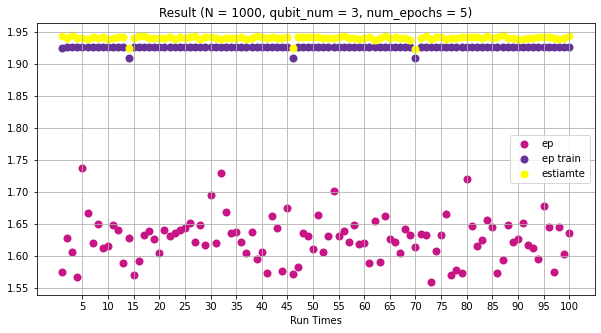

平均時間 : 39.105


In [3]:
plt.figure(figsize=(10,5))
plt.title("Result (N = 1000, qubit_num = 3, num_epochs = 5)")
tl = []
for i in times_list_1:
    if i % 5 == 0:
        tl.append(i)

plt.scatter(times_list_1, ep_list_1, label='ep', color='mediumvioletred', linewidth=2)
plt.scatter(times_list_1, ep_train_list_1, label='ep train', color='rebeccapurple', linewidth=2)
plt.scatter(times_list_1, estimate_list_1, label='estiamte', color='yellow', linewidth=2)

plt.grid()
plt.legend(loc='best')
plt.xticks(tl) 
plt.xlabel('Run Times')
plt.show()
print('平均時間 :',run_time_1/len(times_list_1))

In [4]:
print(in_ci_1)
#print(in_ci_2)
#print(in_ci_3)
#print(run_time_1)
#print(run_time_2)
#print(run_time_3)
#print(len(times_list_1))
#print(len(times_list_2))
#print(len(times_list_3))

0
